In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product


import networkx as nx

import dgl
from dgl.dataloading import GraphDataLoader
import torch
import torch.nn as nn


from torch.utils.data import SubsetRandomSampler

from sklearn.model_selection import StratifiedKFold

import pickle

from copy import deepcopy
from utils import *
from RGCN import *



In [2]:
pickle_name = 'nx_dataset.pickle'
with open(pickle_name, 'rb') as f:
    train_set, val_set, test_set = pickle.load(f)

In [3]:
# id of edge type required for DGL relgraphconv
e2id = {'title':0, 
        'link':1,
        'domain':2,
        'reversed_title':3,
        'reversed_link':4,
       }
# store result pickle for next analysis if required
result_name = 'all_but_sna 5edges.pickle'
num_epochs=100

# parameters for grid_search
hidden_size = [16, 24, 32]
dropout = [0., 0.3, 0.5]
lr = [0.01, 0.005, 0.001]
model_params = list(product(hidden_size, dropout, lr))


# select initial node embedding
# [one hot level, time difference, missing time flag]
# node_embedding_function = all_but_sna_node_embedding

# [one hot level, time difference, missing time flag, *sna features]
# node_embedding_function = all_node_embedding

# [*sna features]
node_embedding_function = sna_node_embedding


In [4]:


train_set = add_time_difference(train_set)
val_set = add_time_difference(val_set)
test_set = add_time_difference(test_set)
print('time done')

# train_set = add_domain(train_set)
# val_set = add_domain(val_set)
# test_set = add_domain(test_set)
# print('domain done')

# train_set = add_backward_edges(train_set)
# val_set = add_backward_edges(val_set)
# test_set = add_backward_edges(test_set)
# print('backward done')

train_set = add_sna(train_set)
val_set = add_sna(val_set)
test_set = add_sna(test_set)
print('sna done')


train_set = edges_to_id(train_set, e2id)
val_set = edges_to_id(val_set, e2id)
test_set = edges_to_id(test_set, e2id)
print('done')

time done
sna done
done


In [5]:
train_set = node_embedding_function(train_set)
val_set = node_embedding_function(val_set)
test_set = node_embedding_function(test_set)

In [6]:
train_graphs = [(dgl.from_networkx(g, node_attrs=["h"], edge_attrs=['type']), torch.tensor([l]).float()) for g, l in train_set]
val_graphs = [(dgl.from_networkx(g, node_attrs=["h"], edge_attrs=['type']), torch.tensor([l]).float()) for g, l in val_set]
test_graphs = [(dgl.from_networkx(g, node_attrs=['h'], edge_attrs=['type']), torch.tensor([l]).float()) for g, l in test_set]

train_labels = [l for _, l in train_set]
val_labels = [l for _, l in val_set]
test_labels = [l for _, l in test_set]

In [7]:
splits=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
split_idxs = splits.split(np.arange(len(train_graphs)), train_labels)

in_feature_size = train_graphs[0][0].ndata['h'].shape[1]
g = train_graphs[0][0]
num_edge_types = dgl.batch([g for g,_ in train_graphs]).edata['type'].max().item() +1
print(num_edge_types)


2


In [8]:
best_test_acc = 0
results = []
for i, (hidden_size, dropout, lr) in enumerate(model_params):
    foldperf = {}
    print(f"model {i+1}/{len(model_params)}")
    print('Model parameters: hidden_size {}, dropout {}, optimizer lr {}'.format(*model_params[i]))
    
    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(train_graphs)), train_labels)):
        model = RGCN(in_feature_size, hidden_size, dropout, num_edge_types)
        model.to(torch.device('cpu'))

        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        train_loader = GraphDataLoader(train_graphs, batch_size=1000, sampler=train_sampler)
        test_loader = GraphDataLoader(train_graphs, batch_size=1000, sampler=test_sampler)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}

        for epoch in tqdm(range(num_epochs)):
            train_loss = train(model,train_loader, optimizer)
            train_acc = evaluate(model, train_loader)
            val_l = val_loss(model,test_loader)
            val_acc = evaluate(model, test_loader)
#             print("{}, {} Loss train/val:{:.3f} / {:.3f} Acc train/val {:.2f} / {:.2f} %".format(fold, epoch, train_loss,
#                                                                                           test_loss,
#                                                                                           100*train_acc,
#                                                                                           100*test_acc))

            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_l)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
        foldperf[f'fold{fold+1}'] = history  
    results.append(foldperf)


model 1/27
Model parameters: hidden_size 16, dropout 0.0, optimizer lr 0.01


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.06it/s]


model 2/27
Model parameters: hidden_size 16, dropout 0.0, optimizer lr 0.005


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.36it/s]


model 3/27
Model parameters: hidden_size 16, dropout 0.0, optimizer lr 0.001


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.95it/s]


model 4/27
Model parameters: hidden_size 16, dropout 0.3, optimizer lr 0.01


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.17it/s]


model 5/27
Model parameters: hidden_size 16, dropout 0.3, optimizer lr 0.005


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.91it/s]


model 6/27
Model parameters: hidden_size 16, dropout 0.3, optimizer lr 0.001


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.92it/s]


model 7/27
Model parameters: hidden_size 16, dropout 0.5, optimizer lr 0.01


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.91it/s]


model 8/27
Model parameters: hidden_size 16, dropout 0.5, optimizer lr 0.005


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.86it/s]


model 9/27
Model parameters: hidden_size 16, dropout 0.5, optimizer lr 0.001


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.18it/s]


model 10/27
Model parameters: hidden_size 24, dropout 0.0, optimizer lr 0.01


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.53it/s]


model 11/27
Model parameters: hidden_size 24, dropout 0.0, optimizer lr 0.005


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.64it/s]


model 12/27
Model parameters: hidden_size 24, dropout 0.0, optimizer lr 0.001


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.47it/s]


model 13/27
Model parameters: hidden_size 24, dropout 0.3, optimizer lr 0.01


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.85it/s]


model 14/27
Model parameters: hidden_size 24, dropout 0.3, optimizer lr 0.005


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.84it/s]


model 15/27
Model parameters: hidden_size 24, dropout 0.3, optimizer lr 0.001


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.91it/s]


model 16/27
Model parameters: hidden_size 24, dropout 0.5, optimizer lr 0.01


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.86it/s]


model 17/27
Model parameters: hidden_size 24, dropout 0.5, optimizer lr 0.005


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.83it/s]


model 18/27
Model parameters: hidden_size 24, dropout 0.5, optimizer lr 0.001


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.93it/s]


model 19/27
Model parameters: hidden_size 32, dropout 0.0, optimizer lr 0.01


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.07it/s]


model 20/27
Model parameters: hidden_size 32, dropout 0.0, optimizer lr 0.005


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.80it/s]


model 21/27
Model parameters: hidden_size 32, dropout 0.0, optimizer lr 0.001


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.99it/s]


model 22/27
Model parameters: hidden_size 32, dropout 0.3, optimizer lr 0.01


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.19it/s]


model 23/27
Model parameters: hidden_size 32, dropout 0.3, optimizer lr 0.005


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.28it/s]


model 24/27
Model parameters: hidden_size 32, dropout 0.3, optimizer lr 0.001


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.11it/s]


model 25/27
Model parameters: hidden_size 32, dropout 0.5, optimizer lr 0.01


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.61it/s]


model 26/27
Model parameters: hidden_size 32, dropout 0.5, optimizer lr 0.005


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.87it/s]


model 27/27
Model parameters: hidden_size 32, dropout 0.5, optimizer lr 0.001


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.66it/s]


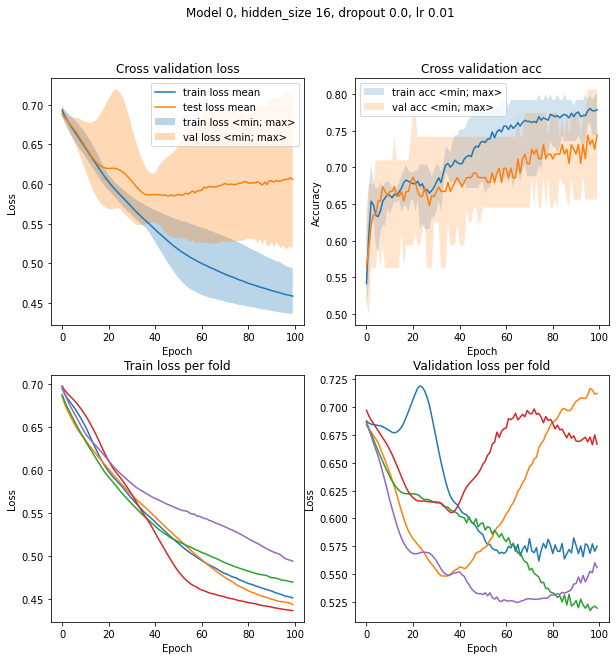

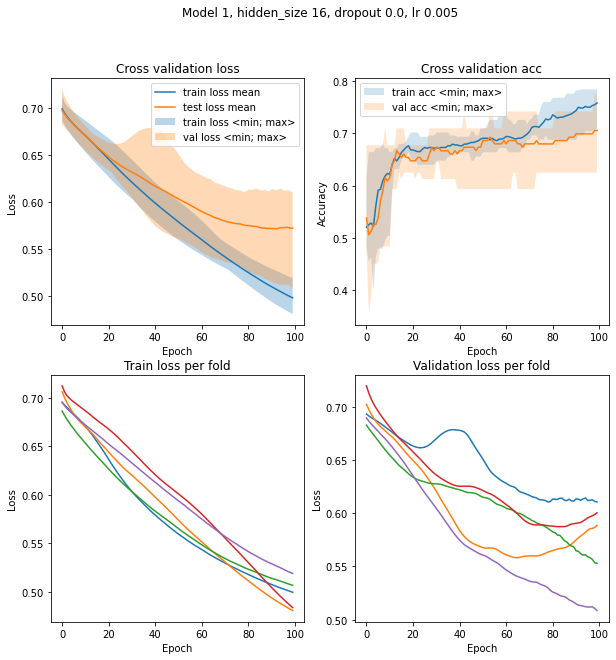

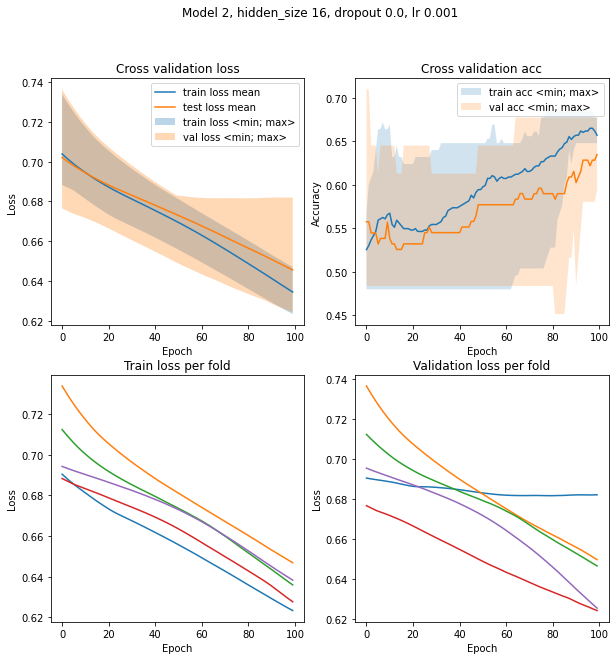

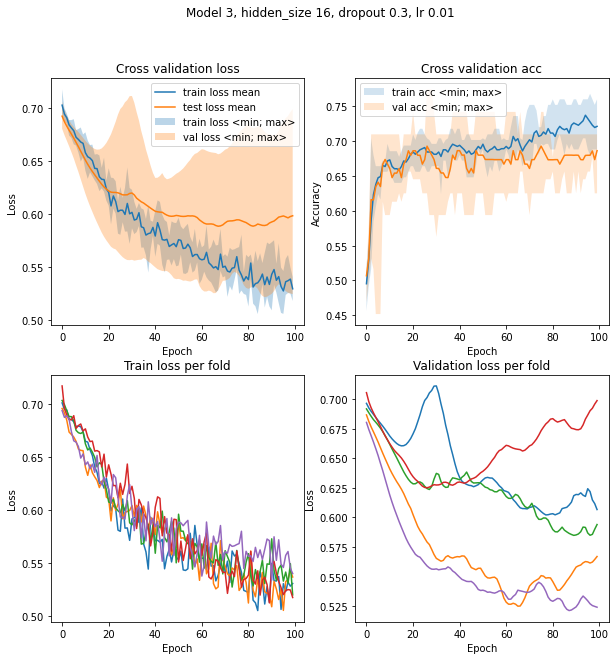

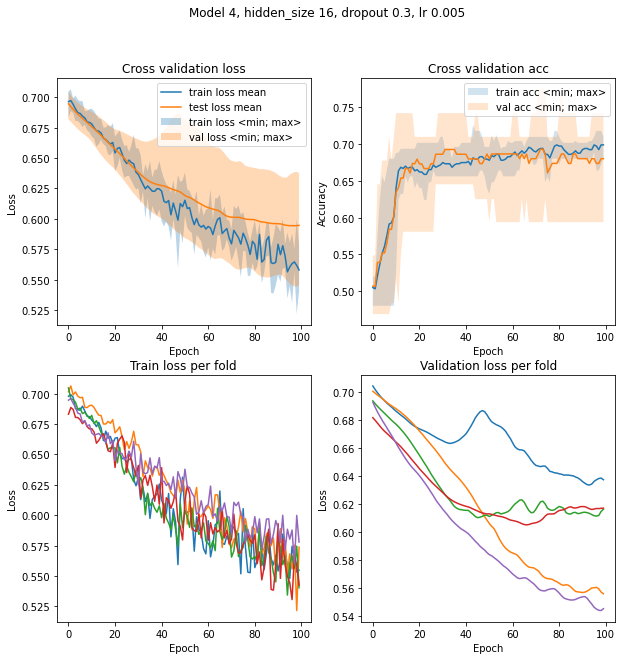

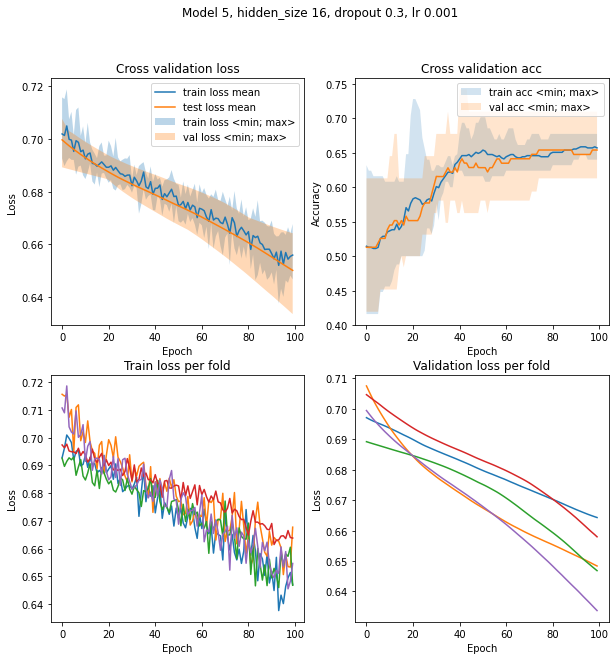

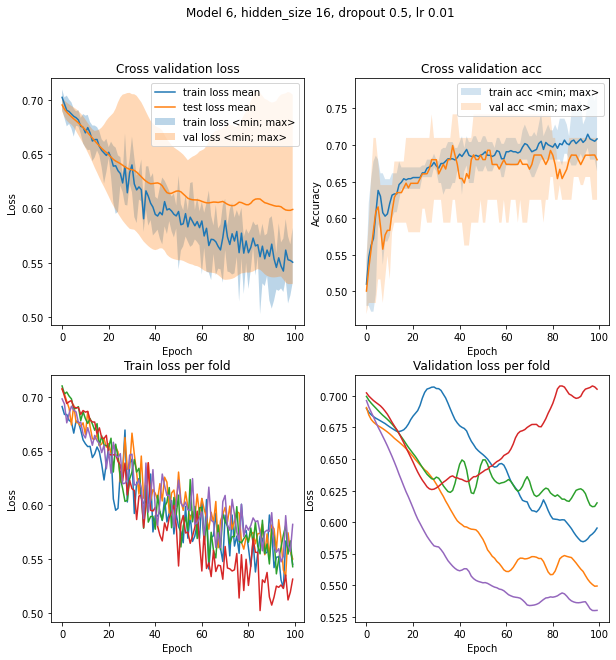

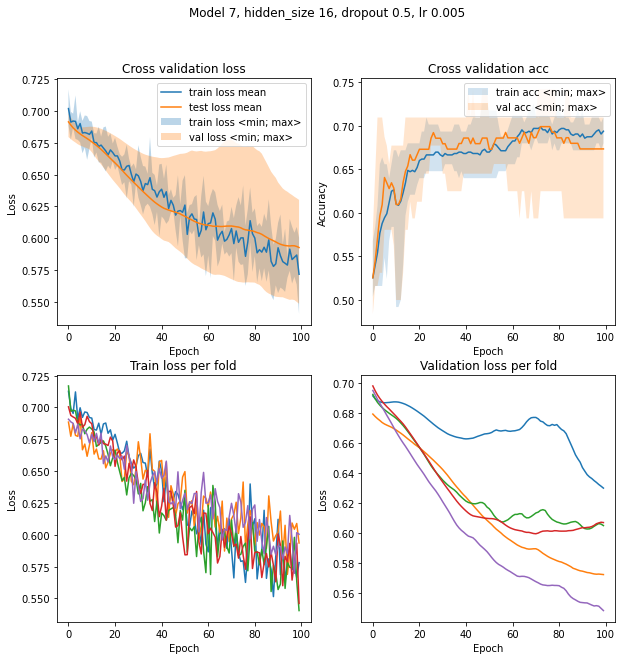

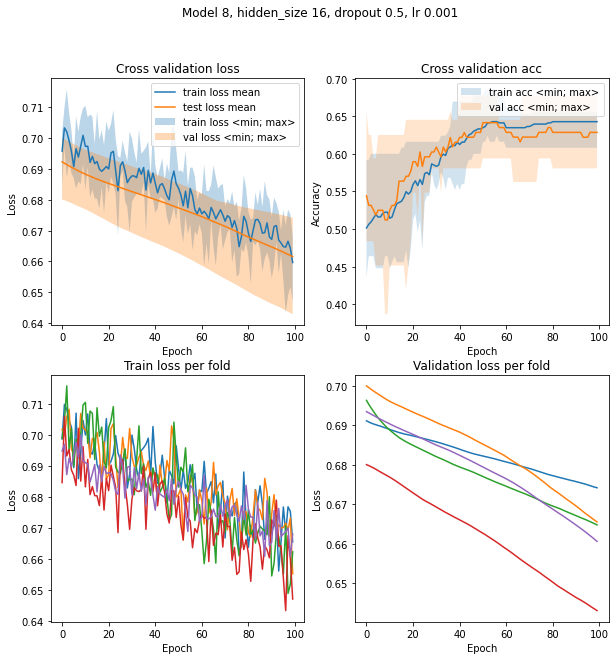

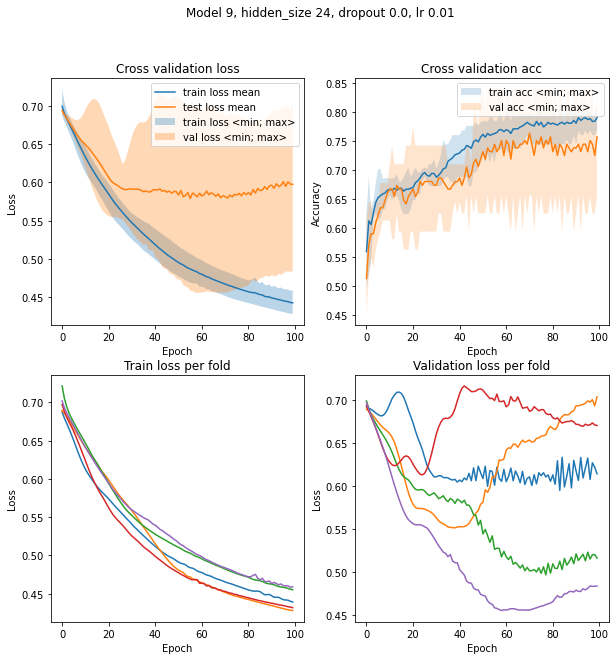

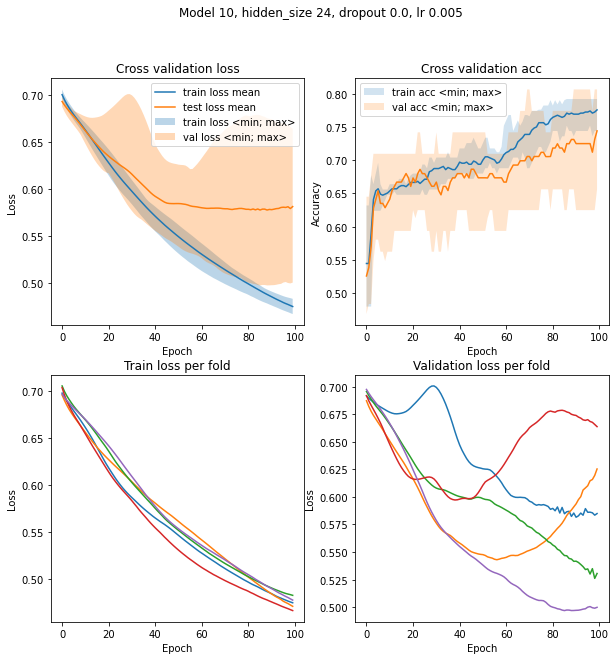

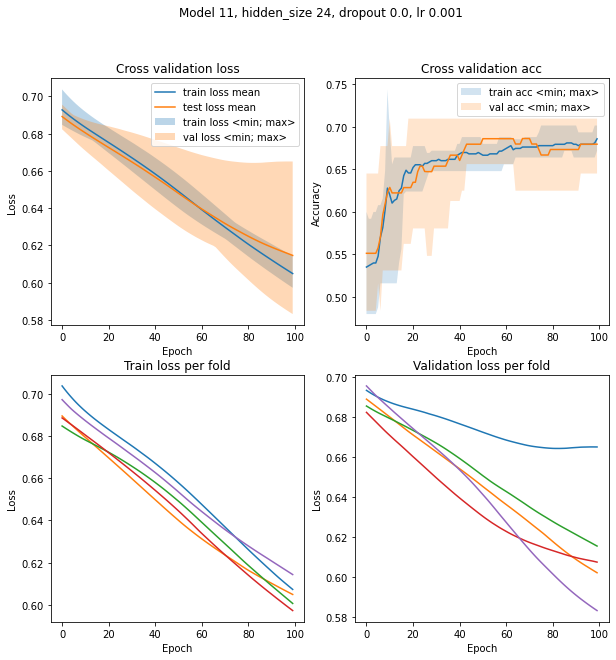

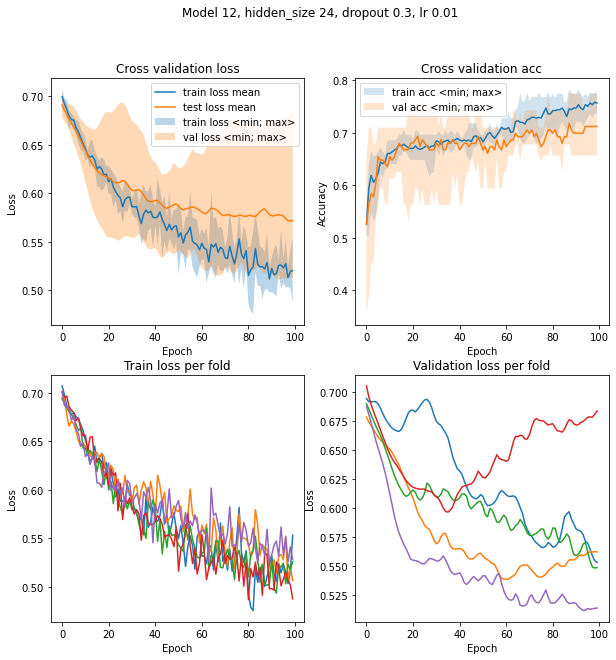

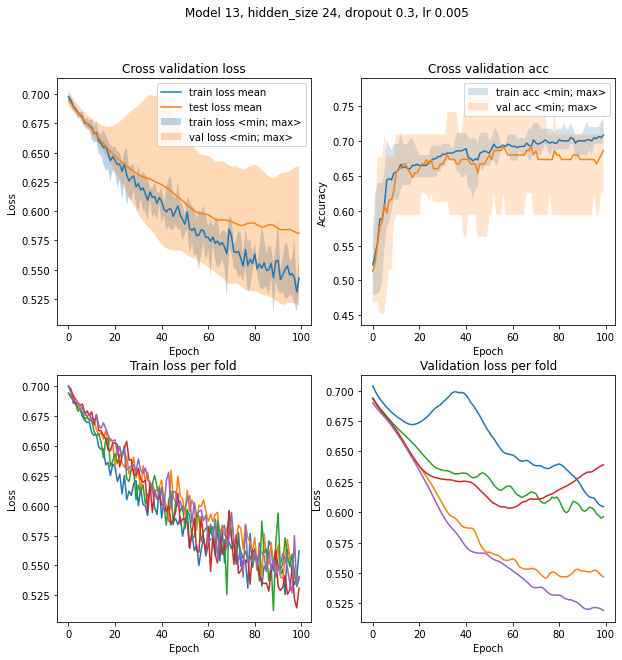

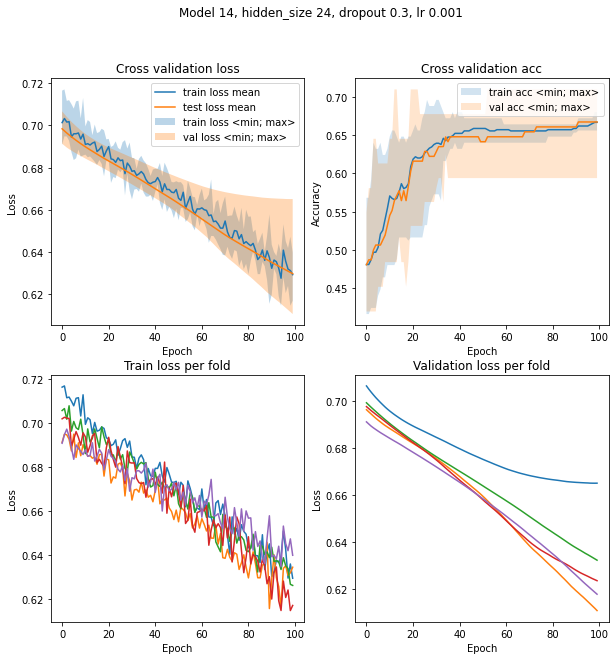

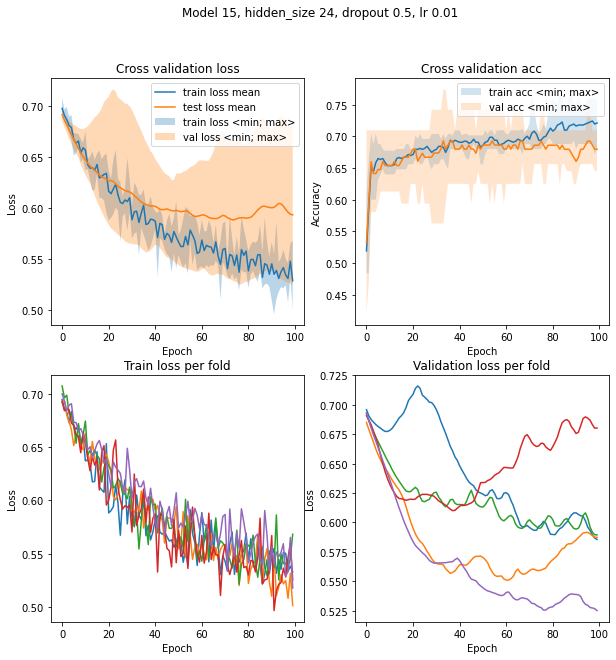

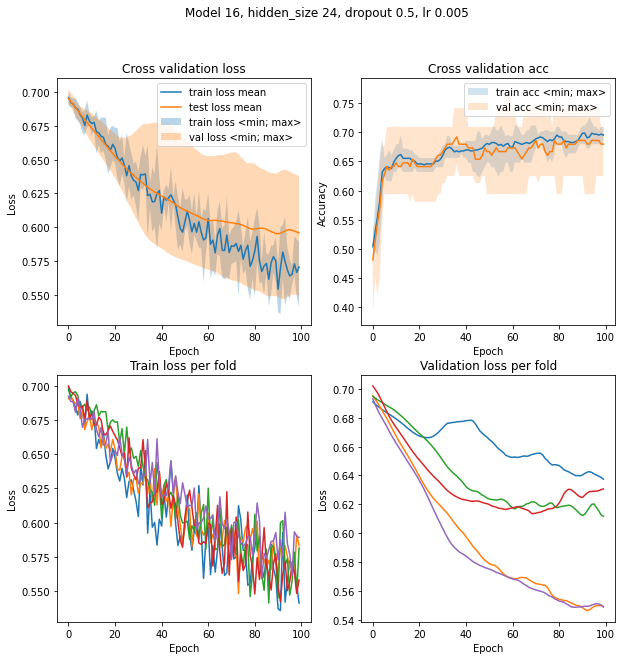

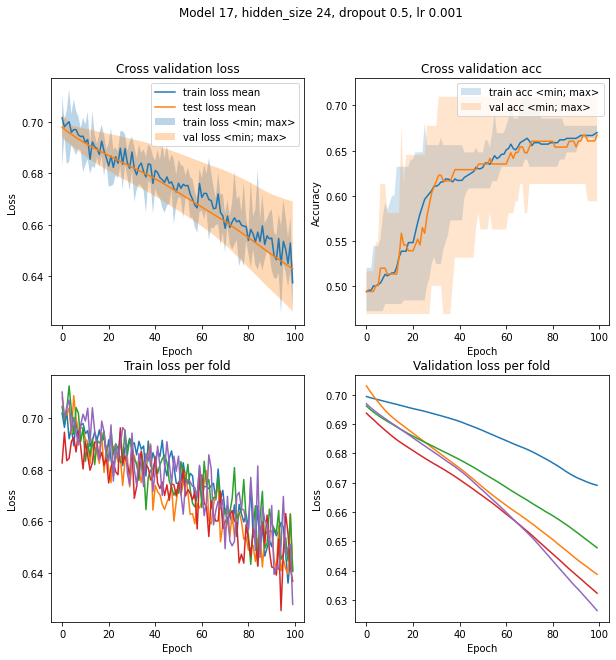

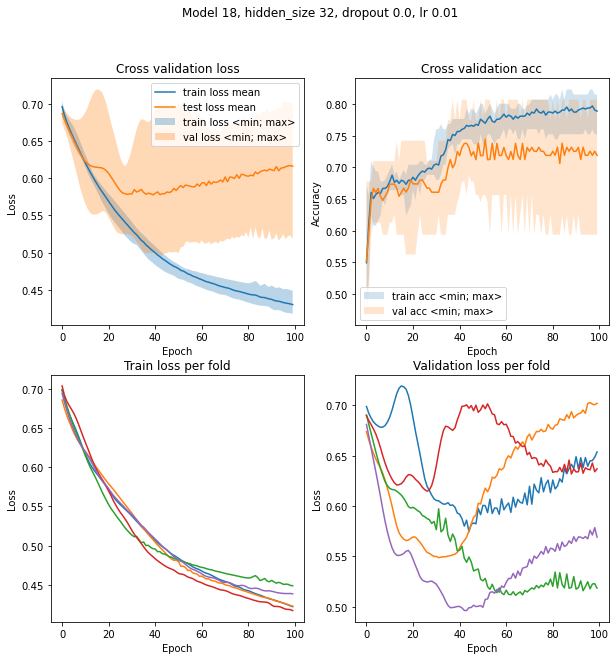

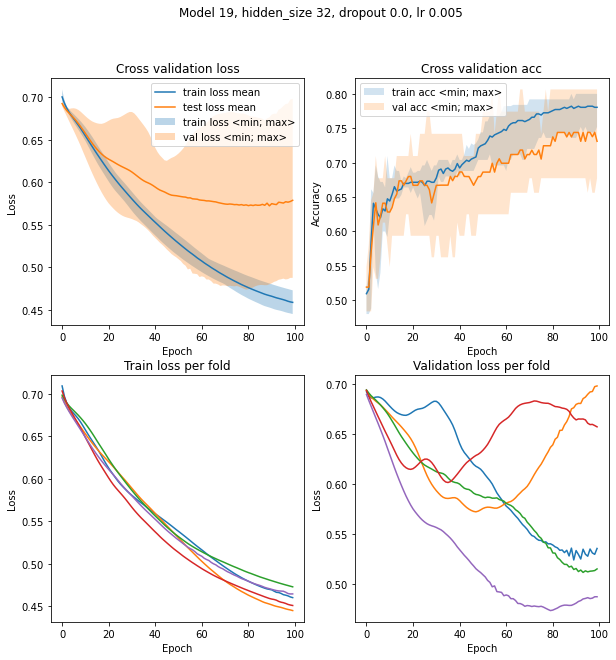

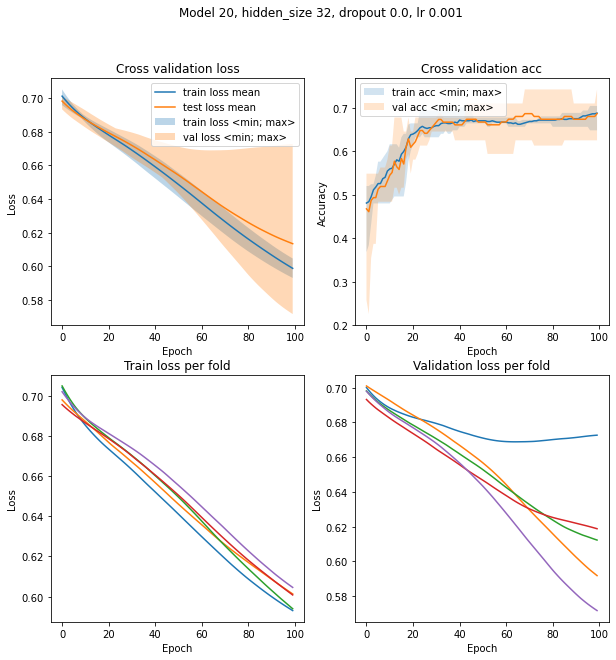

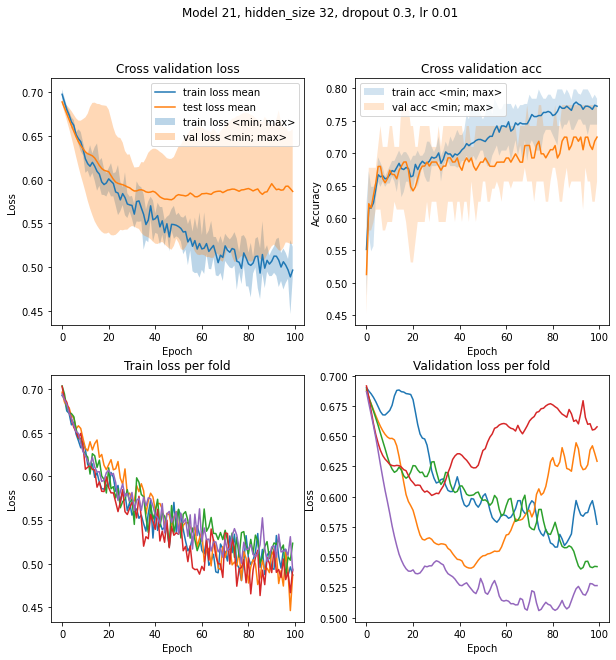

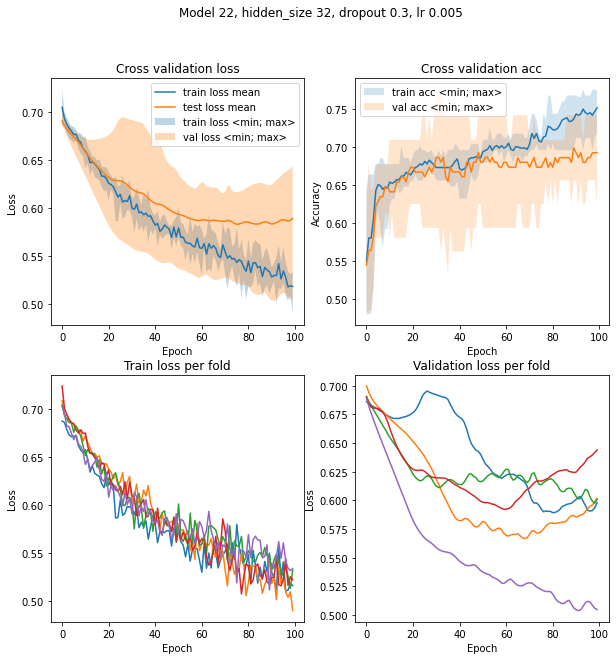

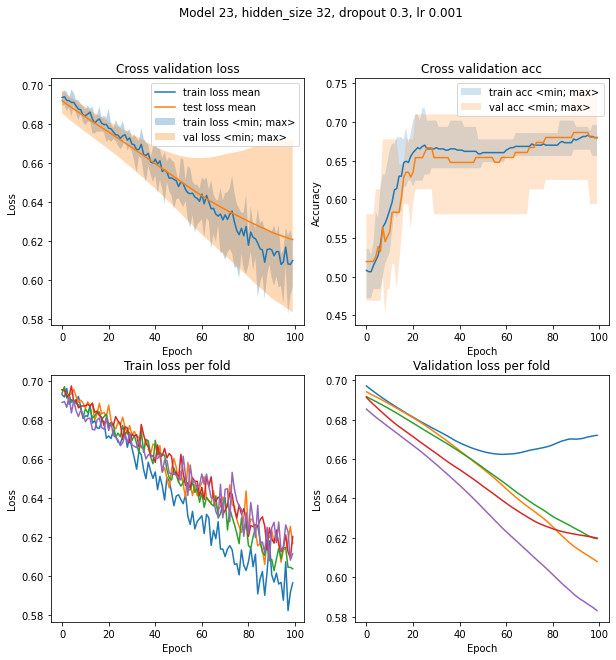

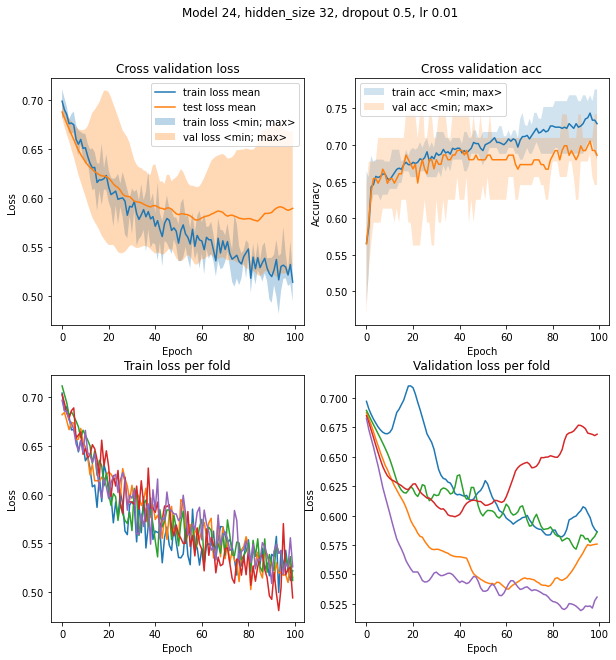

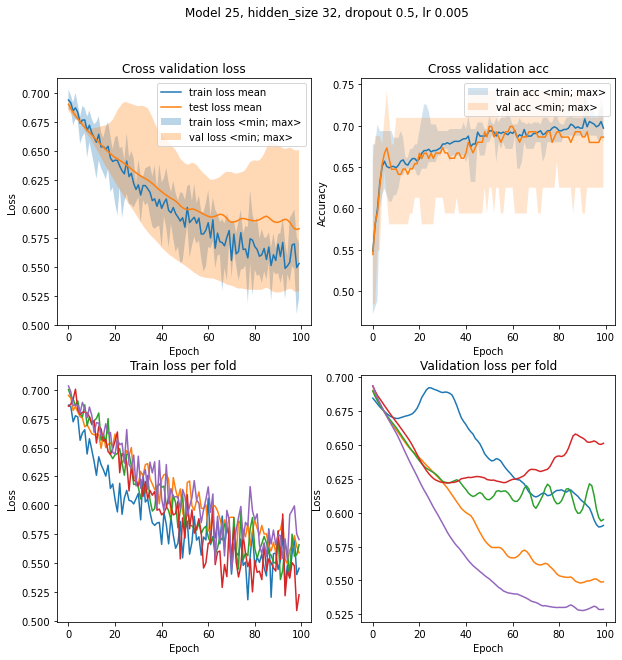

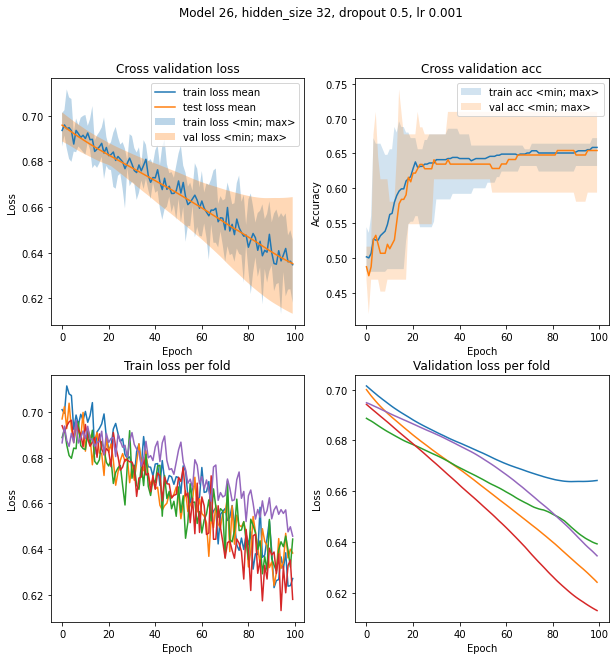

In [9]:
for i, foldperf in enumerate(results):
    train_loss = np.vstack([foldperf[fold]['train_loss'] for fold in foldperf])
    val_losses = np.vstack([foldperf[fold]['val_loss'] for fold in foldperf])
    train_acc = np.vstack([foldperf[fold]['train_acc'] for fold in foldperf])
    val_acc = np.vstack([foldperf[fold]['val_acc'] for fold in foldperf])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(f'Model {i}, hidden_size {model_params[i][0]}, dropout {model_params[i][1]}, lr {model_params[i][2]}')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.title.set_text('Cross validation loss')
    ax1.fill_between(range(num_epochs), train_loss.min(0), train_loss.max(0), alpha=0.3, label="train loss <min; max>")
    ax1.fill_between(range(num_epochs), val_losses.min(0), val_losses.max(0), alpha=0.3, label="val loss <min; max>")

    ax1.plot(range(num_epochs), train_loss.mean(0), label='train loss mean')
    ax1.plot(range(num_epochs), val_losses.mean(0), label='test loss mean')
    ax1.legend()
    
        
    
    ax2.title.set_text("Cross validation acc")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.fill_between(range(num_epochs), train_acc.min(0), train_acc.max(0), alpha=0.2, label="train acc <min; max>")
    ax2.fill_between(range(num_epochs), val_acc.min(0), val_acc.max(0), alpha=0.2, label="val acc <min; max>")

    ax2.plot(range(num_epochs), train_acc.mean(0))

    ax2.plot(range(num_epochs), val_acc.mean(0))
    ax2.legend()

    
    
    ax3.title.set_text('Train loss per fold')
    for l in train_loss:
        ax3.plot(l)
#     for l in train_loss:
#         ax3.plot(l, 'b-', alpha=0.5)
#     for l in test_loss:
#         ax3.plot(l, 'r-', alpha=0.5)
#     ax3.plot(np.convolve(train_loss.mean(0), np.ones(20)/20, mode='valid'), label='train loss')
#     ax3.plot(np.convolve(test_loss.mean(0), np.ones(20)/20, mode='valid'), label='test loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')

    
    ax4.title.set_text('Validation loss per fold')
    for l in val_losses:
        ax4.plot(l)
#     ax3.plot(np.convolve(train_loss.mean(0), np.ones(20)/20, mode='valid'), label='train loss')
#     ax3.plot(np.convolve(test_loss.mean(0), np.ones(20)/20, mode='valid'), label='test loss')
    ax4.set_ylabel('Loss')
    ax4.set_xlabel('Epoch')
    plt.show()


In [10]:
accs = []
for foldperf in results:
    accs.append(np.vstack([foldperf[fold]['val_acc'] for fold in foldperf]).mean(0).max())

best_params = model_params[np.asarray(accs).argmax()]
mean_cv_val_acc = 100*np.asarray(accs).max()


In [11]:
hidden_size, dropout, lr = best_params
model = RGCN(in_feature_size, hidden_size, dropout, num_edge_types)
model.to(torch.device('cpu'))

train_loader = GraphDataLoader(train_graphs, batch_size=1000)
val_loader = GraphDataLoader(val_graphs, batch_size=1000)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
train_losses = []
val_losses = []
train_accs = []
val_accs = []
models = []
for epoch in range(num_epochs):
    
    train_loss = train(model,train_loader, optimizer)
    train_acc = evaluate(model, train_loader)
    val_l = val_loss(model,val_loader)
    val_acc = evaluate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_l)
    val_accs.append(val_acc)
    print("epoch: {} Loss train/val:{:.3f} / {:.3f} Acc train/val {:.2f} / {:.2f} %".format(epoch, train_loss,
                                                                              val_l,
                                                                              100*train_acc,
                                                                              100*val_acc))
    models.append(deepcopy(model))

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 0 Loss train/val:0.705 / 0.695 Acc train/val 48.08 / 47.50 %
epoch: 1 Loss train/val:0.697 / 0.686 Acc train/val 48.08 / 47.50 %
epoch: 2 Loss train/val:0.691 / 0.679 Acc train/val 55.13 / 47.50 %
epoch: 3 Loss train/val:0.686 / 0.671 Acc train/val 56.41 / 67.50 %
epoch: 4 Loss train/val:0.681 / 0.664 Acc train/val 64.74 / 70.00 %
epoch: 5 Loss train/val:0.677 / 0.656 Acc train/val 66.03 / 70.00 %
epoch: 6 Loss train/val:0.672 / 0.648 Acc train/val 65.38 / 70.00 %
epoch: 7 Loss train/val:0.667 / 0.638 Acc train/val 66.03 / 72.50 %
epoch: 8 Loss train/val:0.661 / 0.629 Acc train/val 65.38 / 70.00 %
epoch: 9 Loss train/val:0.656 / 0.620 Acc train/val 66.03 / 70.00 %
epoch: 10 Loss train/val:0.650 / 0.611 Acc train/val 66.67 / 70.00 %
epoch: 11 Loss train/val:0.644 / 0.602 Acc train/val 67.31 / 72.50 %
epoch: 12 Loss train/val:0.638 / 0.594 Acc train/val 67.31 / 72.50 %
epoch: 13 Loss train/val:0.632 / 0.587 Acc train/val 66.67 / 70.00 %
epoch: 14 Loss train/val:0.627 / 0.582 Acc t

<Figure size 432x288 with 0 Axes>

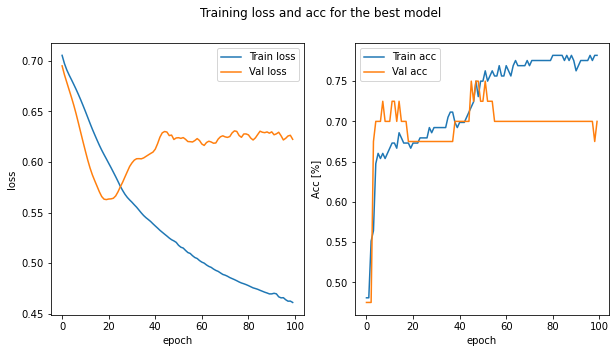

In [12]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
plt.suptitle('Training loss and acc for the best model')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.plot(train_losses, label='Train loss')
ax1.plot(val_losses, label='Val loss')
ax1.legend()

ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc [%]')
ax2.plot(train_accs, label='Train acc')
ax2.plot(val_accs, label='Val acc')
ax2.legend()

plt.show()

In [13]:
test_loader = GraphDataLoader(test_graphs, batch_size=1000)
best_model = models[np.argmax(np.asarray(val_accs))]
acc = 100*evaluate(best_model, test_loader)

print('Best model parameters found by CV: hidden size {}, dropout {}, Adam learning rate{}'.format(*best_params))
print('This model achieved {:.2f}% mean CV validation accuracy'.format(mean_cv_val_acc))
print('The best validation accuracy during training is {:.2f} after {} epochs'.format(100*np.max(np.asarray(val_accs)), np.argmax(np.asarray(val_accs))))
print('This model achieved {:.2f} % test acc'.format(acc))

Best model parameters found by CV: hidden size 24, dropout 0.0, Adam learning rate0.01
This model achieved 76.35% mean CV validation accuracy
The best validation accuracy during training is 75.00 after 45 epochs
This model achieved 59.18 % test acc


In [14]:
# save results
data = []
for param, result in zip(model_params, results):
    data.append({'params':param, 'results':result})
with open(result_name, 'wb') as f:
    pickle.dump(data, f)